In [4]:
#setting system path
import sys
sys.path.append('/home/tobias/data/libs')
base_path = '/home/tobias/data/'

In [5]:
#loading some stuff 
import matplotlib.pyplot as plt
import numpy as np
import pickle 
import datetime


In [6]:
import pandas as pd

In [7]:
#now loading all the necessary data files
#now loading the pickle file containing the audiogram data
with open(base_path + "AllReturns.pkl", "rb") as input_file:
    RET = pickle.load(input_file)
print("Read return data from pickle file")

with open(base_path + "LatestRFTSetting.pkl", "rb") as input_file:
    RFT = pickle.load(input_file)
print("Read RFT from pickle file")

with open(base_path + "sub_ADL.pkl", "rb") as input_file:
    sub_ADL = pickle.load(input_file)
print("Read use-time from pickle file")


Read return data from pickle file
Read RFT from pickle file
Read use-time from pickle file


In [8]:
RFT_Setting = RFT[['SerialNumber','HearingInstrumentId']]
RET_basis = RET[['SerialNumber','RootCause', 'ReturnDate']]

In [9]:
sub_ADL.rename(columns={'ADLRawData_HearingInstrumentId':'HearingInstrumentId'}, inplace = True)

In [10]:
#now try to merge the dataframes 
tmp = RFT_Setting.merge(RET_basis,on='SerialNumber',how='inner')
use_time_returns = pd.merge(sub_ADL,tmp.reset_index(), on ='HearingInstrumentId', how='inner')

In [11]:
cleaned_df = []
cnt = 0
hi_id_return = []
for hi_id, group in use_time_returns.groupby('HearingInstrumentId'):
    if(cnt%1000 == 0):
        print(cnt)
    cleaned_df.append(group.drop_duplicates(subset='ADLRawData_CreationTime'))
    hi_id_return.append(hi_id)
    cnt += 1
    
cleaned_df = pd.concat(cleaned_df)    

0
1000


In [12]:
cleaned_df.set_index(cleaned_df['ADLRawData_CreationTime'],inplace=True)

In [13]:
sub_ADL['class'] = 0
sub_ADL.loc[sub_ADL['HearingInstrumentId'].isin(hi_id_return), 'class'] = 1

In [14]:
#calculating time between last ADL and return
diff_days = []
hi_id_last_ADL = []

cnt = 0

for hi_id, group in cleaned_df.groupby('HearingInstrumentId'):        
        if(cnt%1000 == 0):
            print(cnt)            
        
        cnt += 1
        
        re_date = group['ReturnDate'].iloc[0]
        
        if (group.iloc[group.index < re_date].empty):
            continue
        
        diff_days.append((pd.Timestamp(re_date) - \
        pd.Timestamp(group.iloc[group.index < re_date].index[-1][:-6])).days)            
        
        if (diff_days[-1] > 30):
            continue
                
        hi_id_last_ADL.append(hi_id)      
        

0
1000


In [15]:
 len(diff_days)

1343

[Text(0, 0, '0'),
 Text(0, 100, '7'),
 Text(0, 200, '15'),
 Text(0, 300, '22'),
 Text(0, 400, '30'),
 Text(0, 500, '37'),
 Text(0, 600, '45'),
 Text(0, 700, '52')]

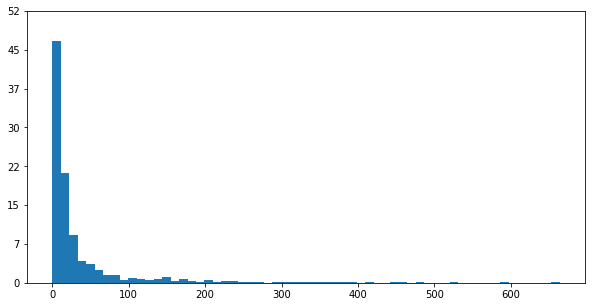

In [16]:
#now plot the day difference histogram 
fig = plt.figure(figsize = (10,5))
ax = fig.gca()

plt.hist(diff_days, bins= 60)
ax.set_yticks([0, 100, 200, 300, 400, 500, 600, 700])
ax.set_yticklabels([round(x / len(diff_days) *100) for x in [0, 100, 200, 300, 400, 500, 600, 700]])


In [17]:
import datetime
import random

def random_date(start, end):
    """Generate a random datetime between `start` and `end`"""
    return start + datetime.timedelta(
        # Get a random amount of seconds between `start` and `end`
        seconds=random.randint(0, int((end - start).total_seconds())),
    )

In [18]:
sub_ADL.keys()[90:]

Index(['ADLProperties_HistogramOnInputPowerPreset1_3',
       'ADLProperties_HistogramOnInputPowerPreset1_4',
       'ADLProperties_HistogramOnInputPowerPreset1_5',
       'ADLProperties_HistogramOnInputPowerPreset1_6',
       'ADLProperties_HistogramOnClassifiedEnvironmentPerPreset_0_0',
       'ADLProperties_HistogramOnClassifiedEnvironmentPerPreset_0_1',
       'ADLProperties_HistogramOnClassifiedEnvironmentPerPreset_0_2',
       'ADLProperties_HistogramOnClassifiedEnvironmentPerPreset_0_3',
       'ADLProperties_HistogramOnClassifiedEnvironmentPerPreset_0_4',
       'ADLProperties_HistogramOnClassifiedEnvironmentPerPreset_0_5',
       'ADLProperties_HistogramOnClassifiedEnvironmentPerPreset_0_6',
       'ADLProperties_HistogramOnClassifiedEnvironmentPerPreset_1_0',
       'ADLProperties_HistogramOnClassifiedEnvironmentPerPreset_1_1',
       'ADLProperties_HistogramOnClassifiedEnvironmentPerPreset_1_2',
       'ADLProperties_HistogramOnClassifiedEnvironmentPerPreset_1_3',
       'AD

In [19]:
abs(sub_ADL['ADLProperties_MeanVolumeControlLevelPerPreset_0'])

ADLRawData_CreationTime
2017-04-29 12:39:26.313943    0.000000
2017-04-29 12:39:26.313943    0.000000
2017-04-29 14:29:44.064030    0.000000
2017-04-29 14:29:44.064030    0.000000
2017-04-29 21:26:06.340520    1.876087
                                ...   
2020-03-05 12:45:06.096467    4.463923
2020-03-05 12:46:55.406801    1.487381
2020-03-05 12:47:28.087881    0.121605
2020-03-05 12:47:52.724813    0.153659
2020-03-05 12:50:28.816529    0.332091
Name: ADLProperties_MeanVolumeControlLevelPerPreset_0, Length: 1792496, dtype: float64

In [20]:
#make column with only positive volume control changes
sub_ADL['MeanVolume'] = abs(sub_ADL['ADLProperties_MeanVolumeControlLevelPerPreset_0'])

In [21]:
sub_ADL['MeanVolume']

ADLRawData_CreationTime
2017-04-29 12:39:26.313943    0.000000
2017-04-29 12:39:26.313943    0.000000
2017-04-29 14:29:44.064030    0.000000
2017-04-29 14:29:44.064030    0.000000
2017-04-29 21:26:06.340520    1.876087
                                ...   
2020-03-05 12:45:06.096467    4.463923
2020-03-05 12:46:55.406801    1.487381
2020-03-05 12:47:28.087881    0.121605
2020-03-05 12:47:52.724813    0.153659
2020-03-05 12:50:28.816529    0.332091
Name: MeanVolume, Length: 1792496, dtype: float64

In [18]:
#now do the filtering of data before return
from random import randrange

colmn = ['ADLProperties_TotalUseTime',
'ADLProperties_NumberOfDeviceBoots',
'ADLProperties_NumberOfPowerDowns',
'ADLProperties_NumberOfPresetSwitches',
'HearingInstrumentId',
'MeanVolume',
'ADLProperties_HistogramOnInputPowerPreset1_0',
'ADLProperties_HistogramOnInputPowerPreset1_1',
'ADLProperties_HistogramOnInputPowerPreset1_2',
'ADLProperties_HistogramOnInputPowerPreset1_3',
'ADLProperties_HistogramOnInputPowerPreset1_4',
'ADLProperties_HistogramOnInputPowerPreset1_5',
'ADLProperties_HistogramOnInputPowerPreset1_6',
'ADLProperties_HistogramOnClassifiedEnvironmentPerPreset_0_0',
'ADLProperties_HistogramOnClassifiedEnvironmentPerPreset_0_1',
'ADLProperties_HistogramOnClassifiedEnvironmentPerPreset_0_2',
'ADLProperties_HistogramOnClassifiedEnvironmentPerPreset_0_3',
'ADLProperties_HistogramOnClassifiedEnvironmentPerPreset_0_4',
'ADLProperties_HistogramOnClassifiedEnvironmentPerPreset_0_5',
'ADLProperties_HistogramOnClassifiedEnvironmentPerPreset_0_6']

sub_sub_ADL = sub_ADL[colmn]

cnt = 0
prereturn = []

for hi_id, group in sub_sub_ADL.groupby('HearingInstrumentId'):        
        if(cnt%1000 == 0):
            print(cnt)
            
        if (hi_id in hi_id_last_ADL):  
            
            tmp = cleaned_df[cleaned_df['HearingInstrumentId'] == hi_id]
            re_date = tmp['ReturnDate'].iloc[0]            
                                                            
            idx = group.index < re_date
            
            time_series = group[idx]                         
            
            prereturn.append(time_series)            
          
        else:
                        
            time_series = group #.iloc[0:randrange(group.shape[0])]                         
            
            prereturn.append(time_series) 
                     
        cnt += 1        

for_resample_df =pd.concat(prereturn)


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000


In [19]:
#now resample all columns
resampled_time_series= []
appended_df = []

colmn = ['ADLProperties_TotalUseTime',
'ADLProperties_NumberOfDeviceBoots',
'ADLProperties_NumberOfPowerDowns',
'ADLProperties_NumberOfPresetSwitches',
'ADLProperties_HistogramOnInputPowerPreset1_0',
'ADLProperties_HistogramOnInputPowerPreset1_1',
'ADLProperties_HistogramOnInputPowerPreset1_2',
'ADLProperties_HistogramOnInputPowerPreset1_3',
'ADLProperties_HistogramOnInputPowerPreset1_4',
'ADLProperties_HistogramOnInputPowerPreset1_5',
'ADLProperties_HistogramOnInputPowerPreset1_6',
'ADLProperties_HistogramOnClassifiedEnvironmentPerPreset_0_0',
'ADLProperties_HistogramOnClassifiedEnvironmentPerPreset_0_1',
'ADLProperties_HistogramOnClassifiedEnvironmentPerPreset_0_2',
'ADLProperties_HistogramOnClassifiedEnvironmentPerPreset_0_3',
'ADLProperties_HistogramOnClassifiedEnvironmentPerPreset_0_4',
'ADLProperties_HistogramOnClassifiedEnvironmentPerPreset_0_5',
'ADLProperties_HistogramOnClassifiedEnvironmentPerPreset_0_6']

cnt = 0
appended_df = []
for hi_id, group in for_resample_df.groupby('HearingInstrumentId'):
    cnt += 1
    if (cnt % 1000 == 0):
        print("Resampled " + str(cnt) + " ADLs")
    time_series = group    
    time_series = time_series.loc[~time_series.index.duplicated(keep='last')]
    time_series = time_series.sort_index()
    
    r_time_series = pd.concat([time_series[colmn].diff().resample('W').sum().interpolate(method = 'linear'),\
                               time_series['MeanVolume'].resample('W').sum().interpolate(method = 'linear')], axis = 1)

        
    for colname, col in r_time_series.iteritems():
        bin = col ==0
        if bin.iloc[-1]==True:
            continue
        for i in np.arange(col.shape[0]):
            start_row = i
            replace_rows = []
            n = 0
            #print("Start row : " + str(start_row))
            while (bin[start_row] == True):
                replace_rows.append(start_row)
                start_row = start_row + 1
                n = n + 1
                #print("Replace rows : " + str(replace_rows))
            if len(replace_rows) > 0:
                bin.iloc[replace_rows] = False            
                replace_value = col.iloc[start_row] / (n+1)
                col.iloc[replace_rows] = replace_value
                col.iloc[start_row] = replace_value

    resampled_time_series = r_time_series / 7
    resampled_time_series['ADLRawData_HearingInstrumentId'] = hi_id
         
    appended_df.append(resampled_time_series)

new_resampled_df = pd.concat(appended_df)

Resampled 1000 ADLs
Resampled 2000 ADLs
Resampled 3000 ADLs
Resampled 4000 ADLs
Resampled 5000 ADLs
Resampled 6000 ADLs
Resampled 7000 ADLs
Resampled 8000 ADLs
Resampled 9000 ADLs
Resampled 10000 ADLs
Resampled 11000 ADLs
Resampled 12000 ADLs
Resampled 13000 ADLs
Resampled 14000 ADLs
Resampled 15000 ADLs
Resampled 16000 ADLs
Resampled 17000 ADLs
Resampled 18000 ADLs
Resampled 19000 ADLs
Resampled 20000 ADLs
Resampled 21000 ADLs
Resampled 22000 ADLs
Resampled 23000 ADLs
Resampled 24000 ADLs
Resampled 25000 ADLs
Resampled 26000 ADLs
Resampled 27000 ADLs
Resampled 28000 ADLs
Resampled 29000 ADLs
Resampled 30000 ADLs
Resampled 31000 ADLs
Resampled 32000 ADLs
Resampled 33000 ADLs
Resampled 34000 ADLs
Resampled 35000 ADLs
Resampled 36000 ADLs
Resampled 37000 ADLs
Resampled 38000 ADLs
Resampled 39000 ADLs
Resampled 40000 ADLs
Resampled 41000 ADLs
Resampled 42000 ADLs


In [ ]:
r_time_series

In [17]:
new_resampled_df['class'] = 0
new_resampled_df.loc[new_resampled_df['ADLRawData_HearingInstrumentId'].isin(hi_id_last_ADL), 'class'] = 1

In [18]:
#saving the resampled file
with open(base_path + 'resampled_last_ADL_before_return.pkl', 'wb') as handle:
    pickle.dump(new_resampled_df, handle)
    
with open(base_path + 'hi_id_ADL_before_return.pkl', 'wb') as handle:
    pickle.dump(hi_id_last_ADL, handle)

    